In [1]:
%matplotlib inline
from sklearn.datasets import load_iris
from  scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import random, sys
import matplotlib.pyplot as plt
from scipy import ndimage
import cPickle as pickle
import scipy.io.wavfile as wav
from pylab import plt
from scipy.signal import butter, lfilter, freqz
from sklearn.cross_validation import train_test_split
from librosa.util import normalize
import kmeans as km
import learnvocabulary as lv

/Users/apple/anaconda/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


# Run kmean++ on Music data
* Import Data
* Use function learnvocabulary to get the centroids, representing the words
* Use function getbof to vectorize the counts per song


X size/number of songs: 80
Number of clips per song: 10
y size: 80
np.array(X_test).shape (20, 10, 10000)
np.array(X_train1).shape (30, 10, 10000)
np.array(X_train2).shape (30, 10, 10000)
----- Running kmeans++ -----
After MFCC X.shape (60, 10, 12, 20)
X_train_flattened.shape (600, 12, 20)


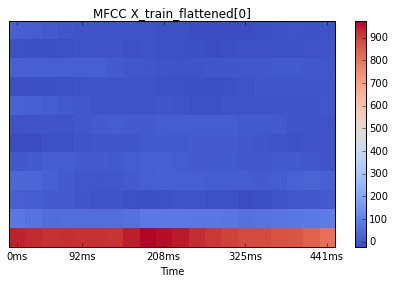

After transpose X_train_flattened.shape (600, 20, 12)
X_train_flattened_norm_final.shape (12000, 12)
Start kmeans
Last distortion: 809.82290812


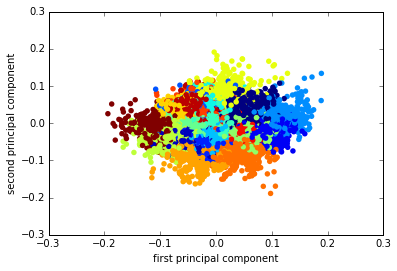

/Users/apple/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


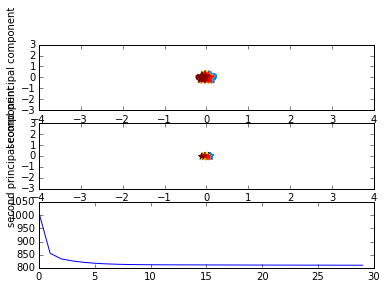

Number of centroids: 20


In [2]:
X, y = lv.getData("./data/data_small8.in", 10000) #data path, window of that clip

#Set two part of training set. One for finding centroid, one for training classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2010)
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5, random_state=2010)

print 'np.array(X_test).shape', np.array(X_test).shape
print 'np.array(X_train1).shape', np.array(X_train1).shape
print 'np.array(X_train2).shape', np.array(X_train2).shape

print '-----', 'Running kmeans++', '-----'
centroids = lv.learnvocabulary(X_train, 20, "kpp", 30, True) #X, k, method, num of Iter, transpose mfcc
print 'Number of centroids:', len(centroids)

# print '-----', 'Running kmeans_multi', '-----'
# cen_t = lv.learnvocabulary(X_train, 20, "multi", 50, False)
# print 'Number of centroids:', len(cen_t)


# Feed to TF-idf
* Used new training data to vectorize BOF from previously computed centroids
* Import X_train_bofCounts into tfidf_transformer

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

X_train2_bofCounts, y_train2_bofCounts = lv.getbof(X_train2, y_train2, centroids, True) #use the second set of training data
tfidf_transformer = TfidfTransformer()
X_train2_tfidf = tfidf_transformer.fit_transform(X_train2_bofCounts)

print "X_train2_tfidf.shape", X_train2_tfidf.shape

# #Tesing the effect if use the same set of data
# X_train1_bofCounts, y_train1_bofCounts = lv.getbof(X_train1, y_train1, centroids, False) #transpose the point
# tfidf_transformer = TfidfTransformer()
# X_train1_tfidf = tfidf_transformer.fit_transform(X_train1_bofCounts)


After transpose X.shape [[[  938.8425218    113.77669274   -28.71740473 ...,    16.2114009
     -13.56643065    -8.94439313]
  [  955.94591155   108.44782074   -33.08284453 ...,    25.45817154
      -7.11431348    -6.2085387 ]
  [  945.12393383    96.9447071    -25.80667303 ...,    25.76009929
      -7.44780363    -3.69238798]
  ..., 
  [  972.85569868    93.86210424   -44.95433458 ...,    32.69084117
       6.44372267    21.41006208]
  [  970.42701521    95.10176071   -45.22906762 ...,    26.66807814
       7.19715632    19.79939982]
  [  987.33273711   118.90594721   -26.59450782 ...,    15.40224879
      -3.25283398     6.13368982]]

 [[  950.75048546    84.77543547   -56.27299986 ...,    34.31137875
      -0.80765382     4.38032999]
  [  961.08664894    69.43091339   -50.04101533 ...,    35.88622007
       0.24801636     6.84083316]
  [ 1050.92829114    60.83519773   -43.55973047 ...,    23.61738642
      -9.14572641     7.67670699]
  ..., 
  [ 1077.46663347    59.55089257    34.02

# Train different classifier
* Testing KNeighborsClassifier and MultinomialNB as our classifier

In [7]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np

print '-------', 'use KNeighborsClassifier and gridsearch', '-------'
param_grid = {'n_neighbors': np.arange(3, 10),'weights':('uniform', 'distance'), 'algorithm':('auto','ball_tree', 'kd_tree', 'brute') }
np.set_printoptions(suppress=True)
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, verbose=3)
grid_search.fit(X_train2_tfidf, y_train2_bofCounts)

print '-------', 'use MultinomialNB and gridsearch', '-------'
clf = MultinomialNB().fit(X_train2_tfidf, y_train2_bofCounts)

# #reuse the same training data to train classifier
# grid_search.fit(X_train1_tfidf, y_train1_bofCounts)
# clf = MultinomialNB().fit(X_train1_tfidf, y_train1_bofCounts)

------- use KNeighborsClassifier and gridsearch -------
Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV] n_neighbors=3, weights=uniform, algorithm=auto ..................
[CV]  n_neighbors=3, weights=uniform, algorithm=auto, score=0.294118 -   0.0s
[CV] n_neighbors=3, weights=uniform, algorithm=auto ..................
[CV]  n_neighbors=3, weights=uniform, algorithm=auto, score=0.405941 -   0.0s
[CV] n_neighbors=3, weights=uniform, algorithm=auto ..................
[CV]  n_neighbors=3, weights=uniform, algorithm=auto, score=0.247423 -   0.0s
[CV] n_neighbors=3, weights=distance, algorithm=auto .................
[CV]  n_neighbors=3, weights=distance, algorithm=auto, score=0.313725 -   0.0s
[CV] n_neighbors=3, weights=distance, algorithm=auto .................
[CV]  n_neighbors=3, weights=distance, algorithm=auto, score=0.386139 -   0.0s
[CV] n_neighbors=3, weights=distance, algorithm=auto .................
[CV]  n_neighbors=3, weights=distance, algorithm=auto, score=0.2

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
/Users/apple/anaconda/lib/python2.7/site-packages/sklearn/neighbors/base.py:229: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "



[CV] n_neighbors=9, weights=distance, algorithm=auto .................
[CV]  n_neighbors=9, weights=distance, algorithm=auto, score=0.306931 -   0.0s
[CV] n_neighbors=9, weights=distance, algorithm=auto .................
[CV]  n_neighbors=9, weights=distance, algorithm=auto, score=0.226804 -   0.0s
[CV] n_neighbors=3, weights=uniform, algorithm=ball_tree .............
[CV]  n_neighbors=3, weights=uniform, algorithm=ball_tree, score=0.294118 -   0.0s
[CV] n_neighbors=3, weights=uniform, algorithm=ball_tree .............
[CV]  n_neighbors=3, weights=uniform, algorithm=ball_tree, score=0.405941 -   0.0s
[CV] n_neighbors=3, weights=uniform, algorithm=ball_tree .............
[CV]  n_neighbors=3, weights=uniform, algorithm=ball_tree, score=0.247423 -   0.0s
[CV] n_neighbors=3, weights=distance, algorithm=ball_tree ............
[CV]  n_neighbors=3, weights=distance, algorithm=ball_tree, score=0.313725 -   0.0s
[CV] n_neighbors=3, weights=distance, algorithm=ball_tree ............
[CV]  n_nei

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    1.2s finished



[CV] n_neighbors=9, weights=distance, algorithm=brute ................
[CV]  n_neighbors=9, weights=distance, algorithm=brute, score=0.313725 -   0.0s
[CV] n_neighbors=9, weights=distance, algorithm=brute ................
[CV]  n_neighbors=9, weights=distance, algorithm=brute, score=0.306931 -   0.0s
[CV] n_neighbors=9, weights=distance, algorithm=brute ................
[CV]  n_neighbors=9, weights=distance, algorithm=brute, score=0.226804 -   0.0s
------- use MultinomialNB and gridsearch -------


# Predict test data

After transpose X.shape [[[ 1007.18683439    36.48845068    -3.00088428 ...,    -0.20750543
      -0.78224031     7.34469074]
  [  996.70238547    43.24881046    -1.73373778 ...,    -1.31828974
      -4.48708646     2.77729418]
  [  979.76533144    34.60161999    -0.13375128 ...,    -4.00290627
     -11.38028604    -7.38385636]
  ..., 
  [  965.59685285    56.94695429   -14.56011764 ...,     9.38921054
     -11.33372592    21.19059153]
  [  969.48606596    52.26416457   -16.71189394 ...,     4.61459179
      -4.55895107    18.54840856]
  [  979.67996905    56.54747306   -11.22465464 ...,    -0.25101414
       2.37545425    10.13386221]]

 [[  970.87410574    59.15682279   -13.11008399 ...,    12.63708999
       5.35489554     2.47859582]
  [  963.1909784     60.64201155   -13.77303509 ...,    12.98690868
       6.16108151     7.82229182]
  [  955.71421496    66.61310309   -17.06657927 ...,    13.25699377
      -2.93544852    14.11163024]
  ..., 
  [  947.37505867    65.49498669   -41.2

<matplotlib.colorbar.Colorbar instance at 0x110f20368>

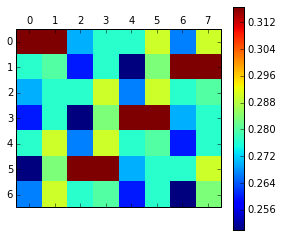

In [9]:
X_test_bofCounts, y_test_bofCounts = lv.getbof(X_test, y_test, centroids, True)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_bofCounts)

predict_knei = grid_search.predict(X_test_tfidf)
predicted_NB = clf.predict(X_test_tfidf)

print grid_search.score(X_test_tfidf, y_test_bofCounts)
print grid_search.best_params_

print "naive bayes", np.mean(predicted_NB == y_test_bofCounts)

# We extract just the scores
scores = [x.mean_validation_score for x in grid_search.grid_scores_]
print np.array(scores).shape
scores = np.array(scores).reshape(7, 8)
print scores.shape
print scores[0]
plt.matshow(scores)
plt.colorbar()
# plt.xticks(np.arange(5), param_grid['gamma'])
# plt.yticks(np.arange(6), param_grid['C']);